# Evaluación de modelos Sentence Transformers (sentence similarity) para generar Text Embreddings para busqueda y recuperación asimetrica

En este cuaderno se evaluan diferentes modelos de procesamiento de lenguaje natural de similitud de sentencias para validar el entrenamiento de Tulio y Beto en el caso de uso de recuperar normas de la ley chilena comparando su titulo con preguntas.

Para ellos:
* con cada modelo se genera una base de datos vectorial con los text embeddings
* dado un set de datos de preguntas y respuestas que contiene las ids de las normas relevantes se hacen busquedas en la base de datos
* para cada pregunta se recupera de forma arbitraria las k normas (titulos de las normas representados como vectores) que tienen menor distancia coseno con la representación vectorial de la pregunta. k es el numero de normas relevantes en el set de datos para la pregunta.
* se calcula la precision de cada modelo como el promedio de la precision de cada recuperacion, esta es el porcentaje de ids de las normas recuperadas que se encuentran en el conjunto de ids relevantes del set de datos.

In [1]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import JSONLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

### Funcion para calcular precision de una recuperacion

In [2]:
def calculate_precision(retrieved_ids, relevant_ids):
    true_positives = retrieved_ids.intersection(relevant_ids)
    if len(retrieved_ids) == 0:
        return 0
    return len(true_positives) / len(retrieved_ids)

### Configuraciónd el set de datos de evaluación, modelos a evaluar y metricas finales.

In [3]:
df = pd.read_csv('./qa_dataset_legal_filter_heuristic_curated.csv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
devide = 'mps' if torch.backends.mps.is_available() else device

model_names = [ 
                'sentence-transformers/all-MiniLM-L6-v2', #Modelo por defecto de ChromaDB
                #Sentence Transformers en español desde HuggingFace
                'Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt',
                'eduardofv/stsb-m-mt-es-distilbert-base-uncased',
                'eduardofv/stsb-m-mt-es-distiluse-base-multilingual-cased-v1',
                'hiiamsid/sentence_similarity_spanish_es',
                'mrm8488/distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es',
                'hackathon-pln-es/bertin-roberta-base-finetuning-esnli',
                'hackathon-pln-es/paraphrase-spanish-distilroberta',
                'jaimevera1107/all-MiniLM-L6-v2-similarity-es',
                'cnrhs/sen-sim-es',
                'dariolopez/roberta-base-bne-finetuned-msmarco-qa-es',
                'dariolopez/roberta-base-bne-finetuned-msmarco-qa-es-mnrl-mn',
                #Modelos de este trabajo
                #'emersoftware/test',
                'emersoftware/tulio-st-msmarco-es-mnrl',
                'emersoftware/beto-st-msmarco-es-mnrl',
                'emersoftware/tulio-st-msmarco-es-mnrl-v2',
                'emersoftware/beto-st-msmarco-es-mnrl-v2',
                #'emersoftware/tulio-chilean-spanish-bert-msmarco-qa-es-mnrl-mn',
                #'emersoftware/tulio-chilean-spanish-bert-finetuned-msmarco-qa-es',
                #Modelos multilingües Sentence Transformers
                'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
                'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
                'sentence-transformers/LaBSE',
                'sentence-transformers/distiluse-base-multilingual-cased-v2',
                'sentence-transformers/distiluse-base-multilingual-cased-v1'
]

metrics_results = {model_name: {'precision': []} for model_name in model_names}

### Evaluación de cada uno de los modelos

In [4]:
for model_name in model_names:
    print(f"Evaluando modelo: {model_name}")
    
    # Cargar y generar embeddings con el modelo actual
    embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs={'device': device})
    db = Chroma(collection_name='titulos', collection_metadata={"hnsw:space": "cosine"}, persist_directory=f"vectordb/{model_name}", embedding_function=embeddings)

    for index, row in df.iterrows():
        # Comprobar si 'idNormas' es una cadena válida
        if pd.notna(row['idNormas']):
            query = row['pregunta']
            query = query.lower()
            query = query.replace('?', '').replace('¿', '').replace('!', '')
            

            relevant_ids = set(row['idNormas'].split(';'))

            retrieved_docs = db.similarity_search(query, k=len(relevant_ids))
            
            retrieved_ids = set(doc.metadata['idNorma'] for doc in retrieved_docs)

            precision = calculate_precision(retrieved_ids, relevant_ids)
            
            # Guardar métricas
            metrics_results[model_name]['precision'].append(precision)

        else:
            # Saltar esta fila si 'idNormas' no es una cadena válida
            print(f"Fila {index} omitida: idNormas es NaN o no válido.")
            continue  # Continuar con la siguiente iteración del bucles

Evaluando modelo: sentence-transformers/all-MiniLM-L6-v2


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluando modelo: Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt
Evaluando modelo: eduardofv/stsb-m-mt-es-distilbert-base-uncased
Evaluando modelo: eduardofv/stsb-m-mt-es-distiluse-base-multilingual-cased-v1
Evaluando modelo: hiiamsid/sentence_similarity_spanish_es
Evaluando modelo: mrm8488/distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es
Evaluando modelo: hackathon-pln-es/bertin-roberta-base-finetuning-esnli
Evaluando modelo: hackathon-pln-es/paraphrase-spanish-distilroberta
Evaluando modelo: jaimevera1107/all-MiniLM-L6-v2-similarity-es
Evaluando modelo: cnrhs/sen-sim-es
Evaluando modelo: dariolopez/roberta-base-bne-finetuned-msmarco-qa-es
Evaluando modelo: dariolopez/roberta-base-bne-finetuned-msmarco-qa-es-mnrl-mn
Evaluando modelo: emersoftware/tulio-st-msmarco-es-mnrl
Evaluando modelo: emersoftware/beto-st-msmarco-es-mnrl
Evaluando modelo: emersoftware/tulio-st-msmarco-es-mnrl-v2
Evaluando modelo: emersoftware/beto-st-msmarco-es-mnrl-v2
Evaluando modelo

### Se muestran los resultados de la evaluación
Precision promedio de los modelos

In [5]:
for model_name, metrics in metrics_results.items():
    avg_precision = np.mean(metrics['precision'])
    print(f"Modelo: {model_name} \t\t Precision: {avg_precision} \t ")

Modelo: sentence-transformers/all-MiniLM-L6-v2 		 Precision: 0.23953452208169188 	 
Modelo: Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt 		 Precision: 0.2660769000391642 	 
Modelo: eduardofv/stsb-m-mt-es-distilbert-base-uncased 		 Precision: 0.18098837745064159 	 
Modelo: eduardofv/stsb-m-mt-es-distiluse-base-multilingual-cased-v1 		 Precision: 0.3038809984564702 	 
Modelo: hiiamsid/sentence_similarity_spanish_es 		 Precision: 0.3528828875526988 	 
Modelo: mrm8488/distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es 		 Precision: 0.22702098739834586 	 
Modelo: hackathon-pln-es/bertin-roberta-base-finetuning-esnli 		 Precision: 0.2972412283733038 	 
Modelo: hackathon-pln-es/paraphrase-spanish-distilroberta 		 Precision: 0.3423782454442832 	 
Modelo: jaimevera1107/all-MiniLM-L6-v2-similarity-es 		 Precision: 0.23996273642500054 	 
Modelo: cnrhs/sen-sim-es 		 Precision: 0.3526208330453613 	 
Modelo: dariolopez/roberta-base-bne-finetuned-msmarco-qa-es 		 Precisio

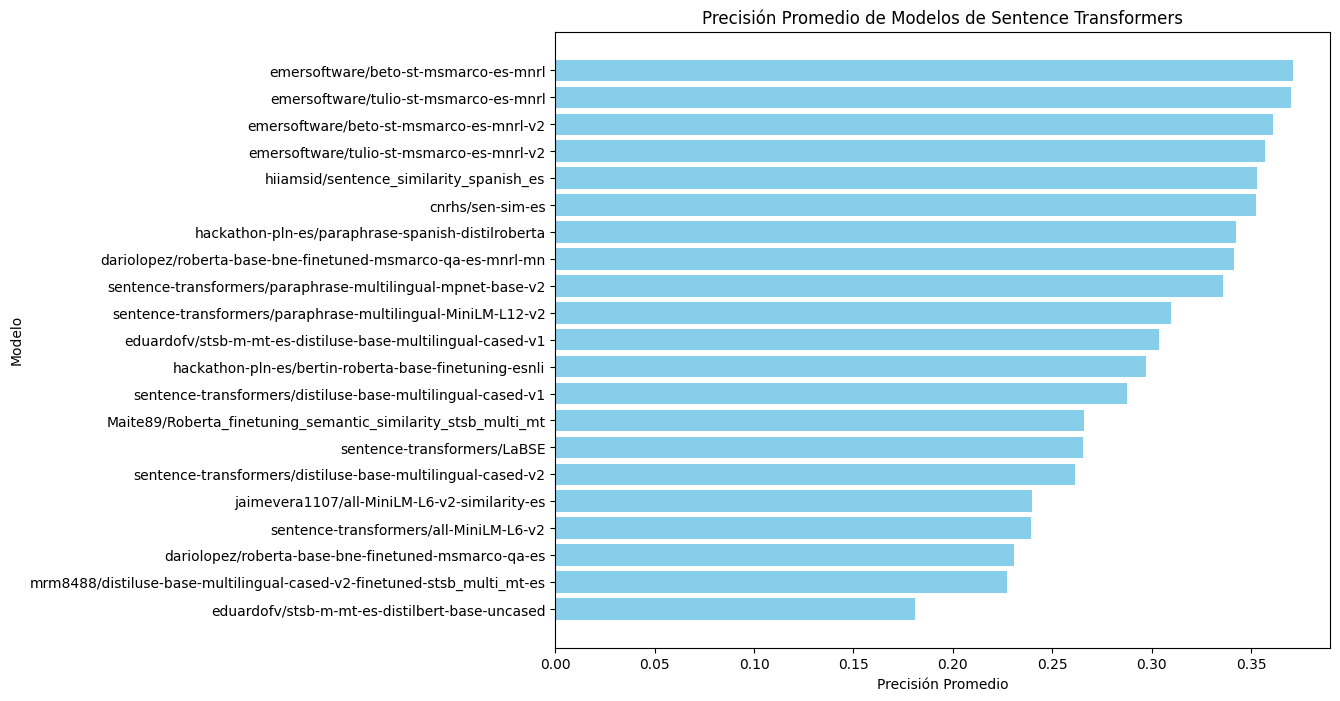

In [6]:
# Calcula la precisión promedio para cada modelo
average_precision = {model: np.mean(metrics['precision']) for model, metrics in metrics_results.items()}

# Ordenar los modelos por precisión promedio en orden decreciente
sorted_models = sorted(average_precision.items(), key=lambda x: x[1], reverse=True)

# Separar los nombres de los modelos y sus precisiones en dos listas
model_names_sorted, precisions_sorted = zip(*sorted_models)

# Crear un gráfico de barras para visualizar los resultados
plt.figure(figsize=(10, 8))
plt.barh(model_names_sorted, precisions_sorted, color='skyblue')
plt.xlabel('Precisión Promedio')
plt.ylabel('Modelo')
plt.title('Precisión Promedio de Modelos de Sentence Transformers')
plt.gca().invert_yaxis()  # Invertir el eje y para que el modelo con mayor precisión esté arriba
plt.show()


In [18]:
random_question = df['pregunta'].sample(n=1).iloc[0]

embeddings = HuggingFaceEmbeddings(model_name='emersoftware/beto-st-msmarco-es-mnrl', model_kwargs={'device': device})
db = Chroma(collection_name='titulos', persist_directory="vectordb/emersoftware/beto-st-msmarco-es-mnrl", embedding_function=embeddings)

retrieved_docs = db.similarity_search(random_question, k=4)


In [19]:
print("Pregunta: ", random_question)
print("Recuperación: ")

for doc in retrieved_docs:
    print(doc.page_content)

Pregunta:  ¿Las entidades deben informar a sus clientes de los fraudes u otros delitos con el uso de instrumentos financieros?
Recuperación: 
establece nuevas exigencias de transparencia y refuerza las responsabilidades de los agentes de los mercados, regula la asesoría previsional, y otras materias que indica
limita la responsabilidad de los titulares o usuarios de tarjetas de pago y transacciones electrónicas en caso de extravío, hurto, robo o fraude
establece normas para las operaciones de credito y otras obligaciones de dinero que indica
compañias de seguros, sociedades anonimas y bolsas de comercio
